In [1]:
import pandas as pd
import numpy as np
np.random.seed(42)
import random
random.seed(42)
from project1 import defs

train: pd.DataFrame = defs.load_asset_value("train")
test: pd.DataFrame = defs.load_asset_value("test")

2024-04-13 15:06:56 -0700 - dagster - DEBUG - system - Loading file from: /home/maguire/ucla/ece219/project1/project1/../data/train using PickledObjectFilesystemIOManager...
2024-04-13 15:06:56 -0700 - dagster - DEBUG - system - Loading file from: /home/maguire/ucla/ece219/project1/project1/../data/test using PickledObjectFilesystemIOManager...


In [2]:
import joblib
embeddings_dict = joblib.load("../../data/glove.300d.embeddings_dict.pkl")

In [3]:
import nltk
embedding_dimension = 300
def embed_document (doc):
    embedding = np.zeros(embedding_dimension, dtype="float32")
    words = nltk.word_tokenize(doc)
    for word in words:
        if word not in embeddings_dict:
            continue
        word_embedding = embeddings_dict[word]
        embedding += word_embedding
    
    return embedding/len(words)

In [4]:
test_embedding = embed_document(train.iloc[0]['full_text'])
test_embedding

array([-1.22798167e-01,  4.31314148e-02, -4.17947806e-02, -8.57153535e-02,
       -4.09106389e-02,  4.56001610e-02, -6.43965527e-02,  8.24142098e-02,
        2.96820141e-02, -1.13758433e+00,  1.33380935e-01,  1.34687247e-02,
       -6.56272769e-02,  7.75078982e-02,  7.95124769e-02,  3.87637913e-02,
       -1.33874252e-01,  4.56261747e-02, -5.89472800e-03, -8.93599242e-02,
       -3.94440293e-02,  1.35767788e-01,  9.39478576e-02,  9.19288099e-02,
       -1.42640606e-01, -5.88997304e-02,  2.69330796e-02, -4.77491692e-02,
       -2.31607668e-02,  5.90757132e-02,  4.43545058e-02,  1.83973283e-01,
       -1.31087542e-01,  9.31881219e-02, -7.11020827e-01,  2.59285141e-03,
        2.29587425e-02,  7.28631914e-02, -5.71402423e-02, -1.85675751e-02,
        5.12302332e-02, -9.71197784e-02, -8.89416710e-02,  1.41757220e-01,
        5.16332462e-02,  1.29449908e-02,  1.10329054e-01,  1.25739053e-01,
       -7.75490925e-02,  4.42259870e-02,  2.17847377e-02, -8.17314535e-02,
        1.31560082e-03, -

In [5]:
test_embedding.shape

(300,)

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from project1.utils.TextPreprocessor import TextPreprocessor
from project1.utils.GloveEmbedder import GloveEmbedder
pipe = Pipeline(
    steps=[
        ('preprocess', TextPreprocessor(type="lemm", n_jobs=2)),
        ("embed", GloveEmbedder("../../data/glove.300d.embeddings_dict.pkl", n_jobs=2)),
        #('classifier', SVC(C=100, probability=True, kernel="linear"))
    ]
)

embeddings = pipe.transform(train['full_text'])

/home/maguire/ucla/ece219/project1/venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
/home/maguire/ucla/ece219/project1/venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


In [8]:
embeddings.shape

(2780, 300)

In [10]:
classifier = SVC(C=100, probability=True, kernel="linear")
classifier.fit(embeddings, train['root_label'])

SVC(C=100, kernel='linear', probability=True)

/home/maguire/ucla/ece219/project1/venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
/home/maguire/ucla/ece219/project1/venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


ROC plot: 


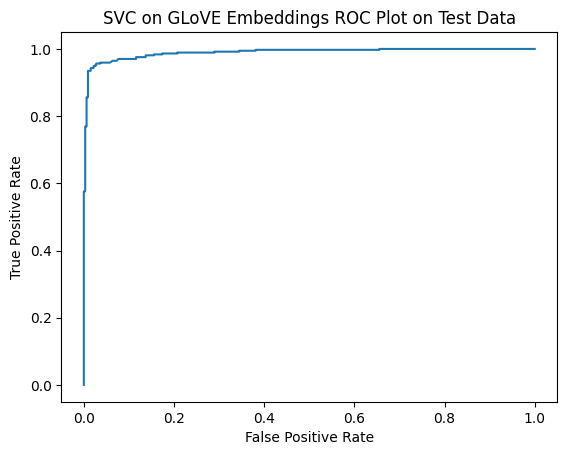

Confusion Matrix: 
[[320   8]
 [ 19 349]]
Accuracy Score: 
0.9612068965517241
Recall Score: 
0.9483695652173914
Precision Score: 
0.9775910364145658
F1 Score: 
0.9627586206896551


In [12]:
from project1.utils.MetricsAnalyzer import MetricsAnalyzer
test_embeddings = pipe.transform(test['full_text'])
metrics = MetricsAnalyzer(classifier, test_embeddings, test['root_label'], pos_label='sports')
metrics.print_all(plot_title="SVC on GLoVE Embeddings ROC Plot on Test Data")